# Rock Scissor Paper Classification

## Import Library

In [14]:
# PIL 라이브러리가 설치되어 있지 않다면 설치
!pip install pillow   

from PIL import Image
import os, glob
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

## Resize of Images

In [7]:
# directory
dir_r = "/aiffel/rock_scissor_paper"
dir_var = ["/scissor*","/rock*", "/paper*"]

dir_path=[]
images=[0,1,2]
for i in range(0,3):
    dir_path.append(os.getenv("HOME") + dir_r + dir_var[i])
    images[i]=glob.glob(dir_path[i] + "/*.jpg")
    print(len(images[i]))


# 파일마다 모두 28x28 사이즈로 바꾸어 저장합니다.
target_size=(28,28)
for i in range(0,3):
    for img in images[i]:
        old_img=Image.open(img)
        new_img=old_img.resize(target_size,Image.ANTIALIAS)
        new_img.save(img,"JPEG")

print("가위 이미지 resize 완료!")

2300
2300
2300
가위 이미지 resize 완료!


## Import Images

In [10]:
def load_data(img_path):
    # 가위 : 0, 바위 : 1, 보 : 2
    number_of_data=2300*3   # 가위바위보 이미지 개수 총합에 주의하세요.
    img_size=28
    color=3
    #이미지 데이터와 라벨(가위 : 0, 바위 : 1, 보 : 2) 데이터를 담을 행렬(matrix) 영역을 생성합니다.
    imgs=np.zeros(number_of_data*img_size*img_size*color,dtype=np.int32).reshape(number_of_data,img_size,img_size,color)
    labels=np.zeros(number_of_data,dtype=np.int32)

    idx=0
    srp_var = ['/scissor*/*.jpg','/rock*/*.jpg','/paper*/*.jpg']
    
    for i in range(0,3):
        for file in glob.iglob(img_path+srp_var[i]):
            img = np.array(Image.open(file),dtype=np.int32)
            imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
            labels[idx]=i   # 가위 : 0
            idx=idx+1
        
    print("학습데이터(x_total)의 이미지 개수는",idx,"입니다.")
    return imgs, labels

image_dir_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper"
(x_total, y_total)=load_data(image_dir_path)
x_total_norm = x_total/255.0   # 입력은 0~1 사이의 값으로 정규화


학습데이터(x_total)의 이미지 개수는 6900 입니다.


## Split the train and test data

In [11]:
# train_test_split
x_train, x_test, y_train, y_test = train_test_split(x_total_norm, y_total, test_size=0.2, shuffle=True, stratify=y_total, random_state=34)

print("x_train shape: {}".format(x_train.shape))
print("x_test shape: {}".format(x_test.shape))
print("y_train shape: {}".format(y_train.shape))
print("y_test shape: {}".format(y_test.shape))

x_train shape: (5520, 28, 28, 3)
x_test shape: (1380, 28, 28, 3)
y_train shape: (5520,)
y_test shape: (1380,)


## Check the images

라벨:  1


(5520,)

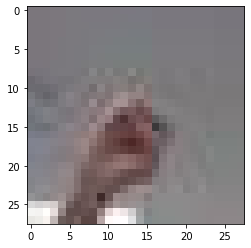

In [12]:
plt.imshow(x_train[0])
print('라벨: ', y_train[0])
y_train.shape

## Deep Learning Network

In [24]:
# 딥러닝 네트워크 설계하기
n_channel_1=15
n_channel_2=25
n_dense=25
n_train_epoch=12

model=keras.models.Sequential()
model.add(keras.layers.Conv2D(n_channel_1, (3,3), activation='relu', input_shape=(28,28,3)))
model.add(keras.layers.MaxPool2D(2,2))
model.add(keras.layers.Conv2D(n_channel_2, (3,3), activation='relu'))
model.add(keras.layers.MaxPooling2D((2,2)))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(n_dense, activation='relu'))
model.add(keras.layers.Dropout(rate=0.02))
model.add(keras.layers.Dense(10, activation='softmax'))

# 만든 모델 확인
model.summary()
model.compile(optimizer='adam',
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])

# 모델 훈련
model.fit(x_train, y_train, epochs=n_train_epoch)

# 모델 평가하기
test_loss, test_accuracy = model.evaluate(x_test,y_test, verbose=2)
print("test_loss: {} ".format(test_loss))
print("test_accuracy: {}".format(test_accuracy))

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_18 (Conv2D)           (None, 26, 26, 15)        420       
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 13, 13, 15)        0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 11, 11, 25)        3400      
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 5, 5, 25)          0         
_________________________________________________________________
flatten_9 (Flatten)          (None, 625)               0         
_________________________________________________________________
dense_18 (Dense)             (None, 25)                15650     
_________________________________________________________________
dropout_4 (Dropout)          (None, 25)               

## 잘못 추론한 확률분포

In [25]:
predicted_result = model.predict(x_test)  # model이 추론한 확률값. 
predicted_labels = np.argmax(predicted_result, axis=1)

idx=0  #1번째 x_test를 살펴보자. 
print('model.predict() 결과 : ', predicted_result[idx])
print('model이 추론한 가장 가능성이 높은 결과 : ', predicted_labels[idx])
print('실제 데이터의 라벨 : ', y_test[idx])

model.predict() 결과 :  [7.0776150e-07 4.1654911e-07 9.9999893e-01 2.9718505e-11 5.5171792e-09
 7.7397327e-10 3.2583672e-10 8.0891183e-11 7.4059908e-12 1.8467930e-10]
model이 추론한 가장 가능성이 높은 결과 :  2
실제 데이터의 라벨 :  2


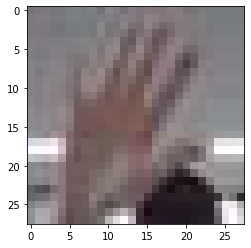

In [26]:
plt.imshow(x_test[idx],cmap=plt.cm.binary)
plt.show()

## 실제와 예측이 다른 경우

예측확률분포: [5.7734263e-01 5.1549933e-04 4.2213273e-01 3.6333759e-07 1.3076379e-06
 2.2342022e-06 8.3360726e-07 6.1653867e-07 1.6373222e-07 3.5200194e-06]
라벨: 2, 예측결과: 0


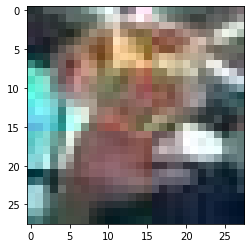

예측확률분포: [9.0436116e-03 7.4903065e-01 2.4192049e-01 3.4398731e-08 5.1888360e-06
 7.2368742e-09 6.7319200e-10 1.5778832e-08 7.0728605e-09 1.2690771e-08]
라벨: 2, 예측결과: 1


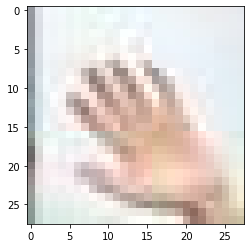

예측확률분포: [2.43914977e-01 6.42880023e-01 1.13159075e-01 9.07147023e-06
 2.50938028e-05 2.44493748e-07 4.51038886e-07 1.71241334e-06
 4.47560251e-06 4.85052624e-06]
라벨: 0, 예측결과: 1


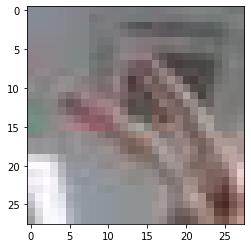

예측확률분포: [8.4235632e-01 8.5890060e-05 1.5755481e-01 9.1721176e-07 1.7879560e-06
 9.3454684e-09 1.5325253e-07 3.8534125e-08 2.0087178e-08 5.7200570e-08]
라벨: 2, 예측결과: 0


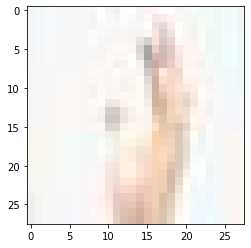

예측확률분포: [6.3899475e-01 2.1723002e-02 3.3917367e-01 2.9981253e-05 5.3173535e-05
 5.8790497e-06 4.3568980e-06 2.3575112e-06 2.5891081e-06 1.0271420e-05]
라벨: 2, 예측결과: 0


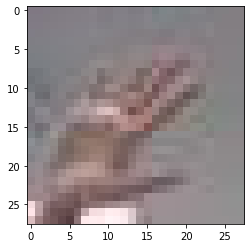

예측확률분포: [4.7678608e-01 4.8900643e-01 3.3761319e-02 6.5779153e-05 2.4191797e-04
 1.2181911e-05 1.0117677e-05 1.5753443e-05 4.0369952e-05 5.9983435e-05]
라벨: 0, 예측결과: 1


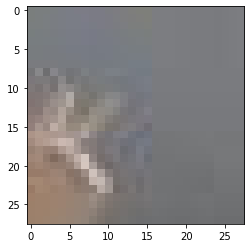

예측확률분포: [4.7159174e-01 4.9400243e-01 3.4214947e-02 3.3678076e-05 1.0918276e-04
 2.5282584e-06 2.9164171e-06 5.5643363e-06 1.8969626e-05 1.8138304e-05]
라벨: 0, 예측결과: 1


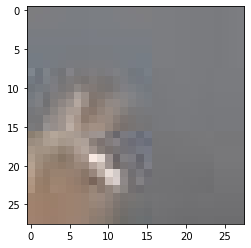

예측확률분포: [1.2306928e-01 5.3201210e-01 3.4491482e-01 3.0276379e-07 3.0897695e-06
 1.8514356e-07 5.4574709e-09 1.5844735e-07 2.6210682e-08 5.3642420e-08]
라벨: 2, 예측결과: 1


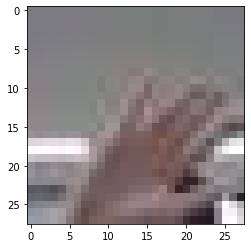

예측확률분포: [3.2577518e-02 9.1334730e-01 5.3953722e-02 7.2821958e-06 9.5125906e-05
 8.6398620e-07 7.8527120e-07 6.3532434e-06 4.9111577e-06 6.1527562e-06]
라벨: 0, 예측결과: 1


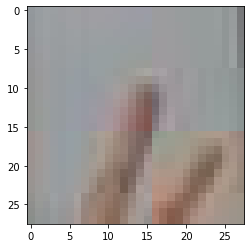

예측확률분포: [3.0926296e-02 4.8017311e-01 4.8829824e-01 2.0838396e-04 1.4328414e-04
 1.4793152e-05 1.5295451e-05 7.9175967e-05 6.2085986e-05 7.9311620e-05]
라벨: 1, 예측결과: 2


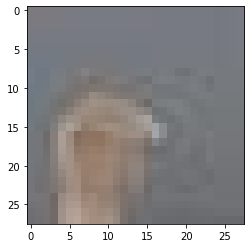

In [30]:
import random
wrong_predict_list=[]
for i, _ in enumerate(predicted_labels):
    # i번째 test_labels과 y_test이 다른 경우만 모아 봅시다. 
    if predicted_labels[i] != y_test[i]:
        wrong_predict_list.append(i)

# wrong_predict_list 에서 랜덤하게 5개만 뽑아봅시다.
samples = random.choices(population=wrong_predict_list, k=10)

for n in samples:
    print("예측확률분포: " + str(predicted_result[n]))
    print("라벨: " + str(y_test[n]) + ", 예측결과: " + str(predicted_labels[n]))
    plt.imshow(x_test[n], cmap=plt.cm.binary)
    plt.show()

## Conclusion

1) 1명의 사진(총300장)으로 트레이닝하고 테스트(총300장) 했을 때 - accuracy 0.33정도
* 이 경우 사진을 찍는 배경이 한명과 다른한명이 다르기 때문에 제대로 학습을 못한 것으로 판단.
* 다양한 배경과 다양한 포즈가 더 많이 필요할 것 같았음.

2) 조원 5명의 사진을 모두 모음 -> 0.2의 비율로 test/train set을 분리하여 테스트 - accuracy 0.96
* 이 경우 정확도는 높아졌지만, 문제를 한번 풀어보고 같은 출제자 문제를 또 풀어보는 것이므로 정확도 높히 나온 것으로 판단.(오버피팅 가능성)
* 예를 들어 train set은 1조의 사진, test set은 2조의 사진으로 구성해서 테스트 해보는 것도 좋을 것 같음.
* 지금은 5명이라는 소수의 사람들이 찍은 사진으로 이루어졌지만 더 다양한 사람들이 찍은 사진을 모아서 테스트 해도 좋을 것 같음.